## Submitted by:
Rotem Amir 319041208
Mark Feldman 320827637
Ron Sharabi 207209297

## Installations

In [1]:
%pip install --upgrade yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime
from scipy.optimize import minimize

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Python script stock price prediction using linear regression or random forest for later use in markovich model

### markovich() function explained:
    Gets the desired stocks to predict upon, as well as test size and amount
    of portfolios to run and which model to use. For each stock, call price_forecast() and get predicted price. Then, calculate annual return
    and covariance matrix for all of the stocks. As learned in class,
    markovich model strength is in its ability to consider the variance of each
    pair or group of stocks in order to get a  better, safer portfolio. For
    each stock give random weight in each simulation, calculate, sharpe ration,
    return and vollatility (risk). Finally, plot the efficiency frontier of all
    the portfolios calculated and mark the safest one, the one eith the highest
    sharp ratio and the one with the highest risk.


### price_forecast() function explained:
    Gets stock name, relevant dates and test size. After downloading stock's
    data from yfinance, 4 different features are selected. data is then split
    into train and test sets, inserted in a linear regression model for training
    and prediction. the prediction received from the model are returned to
    markovich function for portfolio analysis.



## Markovich Model



### Functions

In [4]:
def calculate_portfolio_performance(returns_df, weights_dict, label, Num_porSimulation):
    """
    """

    # Align returns and weights
    relevant_returns = returns_df[list(weights_dict.keys())]
    relevant_returns = relevant_returns.dropna()

    weights_series = pd.Series(weights_dict)
    weights_series /= weights_series.sum()

    port_returns = relevant_returns.mul(weights_series, axis=1).sum(axis=1)

    cumulative_value = (1 + port_returns).cumprod() * Num_porSimulation
    cumulative_value.name = label
    return cumulative_value


In [29]:
def price_forecast(stock, start_date, end_date, record_percentage_to_predict, clf):
    """

    """
    df = yf.download(stock, start=start_date, end=end_date)

    df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
    df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume']]

    forecast_col = 'Close'
    # forecast_col = 'Adj. Close'
    df.fillna(value=-99999, inplace=True)
    forecast_out = int(math.ceil(record_percentage_to_predict * len(df)))
    df['label'] = df[forecast_col].shift(-forecast_out)
    print(df.head())


    X = np.array(df.drop(['label'], axis=1))
    X = preprocessing.scale(X)
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]
    df.dropna(inplace=True)
    df['Close'].plot()
    y = np.array(df['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=record_percentage_to_predict, random_state=2)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(confidence)
    forecast_set = clf.predict(X_lately)
    df['Forecast'] = np.nan

    last_date = df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day

    for i in forecast_set:
        next_date = datetime.datetime.fromtimestamp(next_unix)
        next_unix += 86400
        df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

    col = df['Forecast']
    col = col.dropna()
    y_pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return col, confidence, rmse

    # return col

In [20]:
def markovich(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict, model_type="linear"):
    """
    Unified portfolio simulation for Markovich (linear regression) and Random Forest.
    model_type: 'linear' for Markovich, 'rf' for Random Forest
    """
    frame = {}
    metrics = []
    for stock in selected:
        if model_type == "rf":
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            model = LinearRegression()

        # price = price_forecast(stock, start_date, end_date, record_percentage_to_predict, model)
        # frame[stock] = price
        price, r2, rmse = price_forecast(stock, start_date, end_date, record_percentage_to_predict, model)
        frame[stock] = price
        print(f"{stock} - R²: {r2:.4f}, RMSE: {rmse:.4f}")

        metrics.append({
            "Stock": stock,
            "Model": model_type,
            "R2": r2,
            "RMSE": rmse
        })
    table = pd.DataFrame(frame)
    plt.plot(table)
    table.to_csv('Out.csv')

    returns_daily = table.pct_change()
    returns_daily.to_csv('Out1.csv')
    returns_annual = ((1 + returns_daily.mean()) ** 254) - 1
    returns_annual.to_csv('Out2.csv')

    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    num_assets = len(selected)
    num_portfolios = Num_porSimulation
    np.random.seed(101)

    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns * 100)
        port_volatility.append(volatility * 100)
        stock_weights.append(weights)

    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}
    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]
    df = pd.DataFrame(portfolio)
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]
    df = df[column_order]

    min_volatility = df['Volatility'].min()
    max_sharpe = df['Sharpe Ratio'].max()
    max_return = df['Returns'].max()
    max_vol = df['Volatility'].max()
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    max_returns = df.loc[df['Returns'] == max_return]
    max_vols = df.loc[df['Volatility'] == max_vol]

    plt.style.use('seaborn-v0_8-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='orange', marker='D', s=200)
    plt.scatter(x=max_vols['Volatility'], y=max_returns['Returns'], c='red', marker='D', s=200)
    plt.style.use('seaborn-v0_8-dark')
    plt.xlabel('Volatility (Std. Deviation) Percentage %')
    plt.ylabel('Expected Returns Percentage %')
    plt.title('Efficient Frontier')
    plt.subplots_adjust(bottom=0.4)

    red_num = df.index[df["Returns"] == max_return]
    yellow_num = df.index[df['Volatility'] == min_volatility]
    green_num = df.index[df['Sharpe Ratio'] == max_sharpe]
    multseries = pd.Series([1, 1, 1] + [100 for stock in selected],
                           index=['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected])
    print("\n--- Max Returns Portfolio ---")
    print(df.loc[red_num[0]].multiply(multseries))

    print("\n--- Safest (Min Volatility) Portfolio ---")
    print(df.loc[yellow_num[0]].multiply(multseries))

    print("\n--- Max Sharpe Ratio Portfolio ---")
    print(df.loc[green_num[0]].multiply(multseries))

    # Get the optimal portfolios as Series
    max_returns_series = df.loc[red_num[0]].multiply(multseries)
    min_volatility_series = df.loc[yellow_num[0]].multiply(multseries)
    max_sharpe_series = df.loc[green_num[0]].multiply(multseries)

    # Convert each Series to a dictionary
    max_returns_dict = max_returns_series.to_dict()
    min_volatility_dict = min_volatility_series.to_dict()
    max_sharpe_dict = max_sharpe_series.to_dict()

    # Combine into a single dictionary
    optimal_portfolios = {
        "max_returns": max_returns_dict,
        "min_volatility": min_volatility_dict,
        "max_sharpe": max_sharpe_dict
    }

    # print(optimal_portfolios)
    with pd.option_context('display.float_format', '%{:,.2f}'.format):
        plt.figtext(0.2, 0.15, "Max returns Porfolio: \n" + df.loc[red_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='red', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.45, 0.15, "Safest Portfolio: \n" + df.loc[yellow_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.7, 0.15, "Sharpe  Portfolio: \n" + df.loc[green_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='green', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
    plt.show()

    # Plot returns by weighths
    # Prepare weight dictionaries
    max_returns_weights = {k.replace(" Weight", ""): v for k, v in max_returns_dict.items() if "Weight" in k}
    min_volatility_weights = {k.replace(" Weight", ""): v for k, v in min_volatility_dict.items() if "Weight" in k}
    max_sharpe_weights = {k.replace(" Weight", ""): v for k, v in max_sharpe_dict.items() if "Weight" in k}

    # Calculate value series
    max_ret_series = calculate_portfolio_performance(returns_daily, max_returns_weights, "Max Returns",Num_porSimulation)
    min_vol_series = calculate_portfolio_performance(returns_daily, min_volatility_weights, "Min Volatility", Num_porSimulation)
    max_sharpe_series = calculate_portfolio_performance(returns_daily, max_sharpe_weights, "Max Sharpe Ratio", Num_porSimulation)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(max_ret_series, label="Max Returns", color="red")
    plt.plot(min_vol_series, label="Safest", color="yellow")
    plt.plot(max_sharpe_series, label="Sharpe Ratio", color="green")

    plt.title("Simulated Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return optimal_portfolios, metrics

## Run Markovich Model with Linear Regression

C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))
d:\studies\s8\algotrade\code\Algotrade\.conda\Lib\site-packages\sklearn\preprocessing\_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Price           Close    HL_PCT PCT_change     Volume       label
Ticker            SPY                             SPY            
Date                                                             
2009-01-02  68.557884  3.995553   2.786374  227566300  107.220833
2009-01-05  68.476753  1.926221   0.237505  240349700  108.088684
2009-01-06  68.934006  1.909794  -0.181544  328260900  109.500969
2009-01-07  66.869019  2.283820  -1.445654  280899200  108.199158
2009-01-08  67.141914  1.583582   0.976040  263834400  108.128166
0.9610825375149159


C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

SPY - R²: 0.9611, RMSE: 26.3686
Price            Close    HL_PCT PCT_change  Volume        label
Ticker         TA35.TA                      TA35.TA             
Date                                                            
2009-01-01  667.390015  2.128178   1.379292       0  1129.430054
2009-01-04  674.239990  1.713038  -0.580967       0  1135.660034
2009-01-05  679.950012  1.438919   0.793068       0  1146.780029
2009-01-06  702.900024  2.960334   2.909095       0  1141.569946
2009-01-07  694.580017  2.172404  -0.465729       0  1144.849976
0.6241897407553575



C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))
C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

TA35.TA - R²: 0.6242, RMSE: 188.3418
Price           Close    HL_PCT PCT_change  Volume      label
Ticker            IEI                          IEI           
Date                                                         
2009-01-02  86.699448  1.115960  -0.940388   78500  99.045494
2009-01-05  86.759804  0.435920  -0.225775  487100  98.948090
2009-01-06  86.842941  0.708356   0.410338  363700  98.858765
2009-01-07  86.978760  0.400941   0.243668   67400  99.053642
2009-01-08  87.144867  0.399999   0.130142   34800  99.118515
0.3836199346564716



C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))
C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

IEI - R²: 0.3836, RMSE: 5.1469
Price           Close    HL_PCT PCT_change   Volume      label
Ticker            LQD                           LQD           
Date                                                          
2009-01-02  54.546375  1.164301  -0.876847  1095800  73.556160
2009-01-05  54.920425  1.638361   1.148279  2938400  73.479782
2009-01-06  55.012585  1.161873   0.217285  2036600  73.511589
2009-01-07  54.551773  1.037407  -0.612401  1675100  73.861809
2009-01-08  54.942139  0.795619   0.735584  1445200  73.861809
0.5645135088756159



C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3946791482.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


LQD - R²: 0.5645, RMSE: 7.8140


C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3285682456.py:27: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(table)
C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3285682456.py:30: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = table.pct_change()



--- Max Returns Portfolio ---
Returns           14.499351
Volatility        25.323836
Sharpe Ratio       0.572557
SPY Weight        47.205837
TA35.TA Weight    51.425067
IEI Weight         1.118475
LQD Weight         0.250621
dtype: float64

--- Safest (Min Volatility) Portfolio ---
Returns            2.325134
Volatility         5.594706
Sharpe Ratio       0.415595
SPY Weight         8.429225
TA35.TA Weight     3.866912
IEI Weight        76.614817
LQD Weight        11.089047
dtype: float64

--- Max Sharpe Ratio Portfolio ---
Returns           12.092989
Volatility        18.571936
Sharpe Ratio       0.651143
SPY Weight        53.214954
TA35.TA Weight    27.386843
IEI Weight         0.742524
LQD Weight        18.655678
dtype: float64


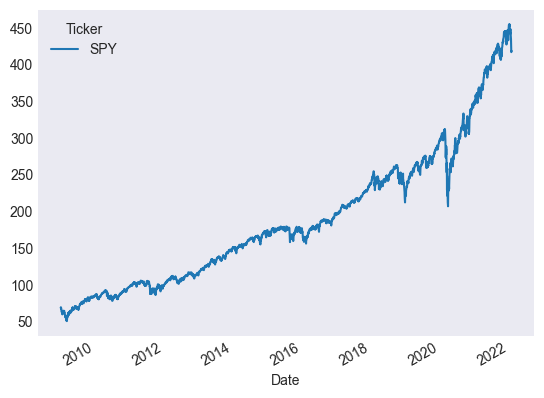

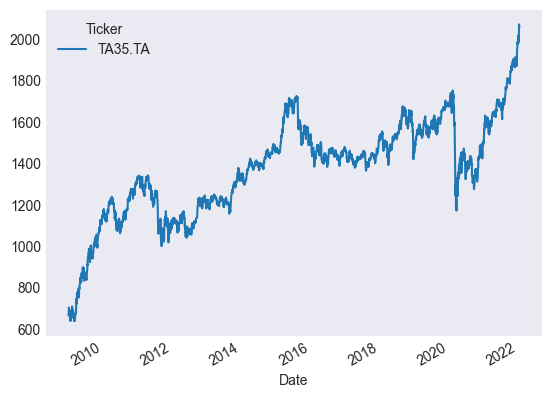

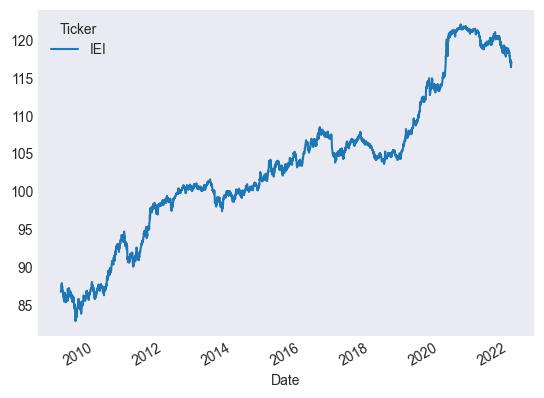

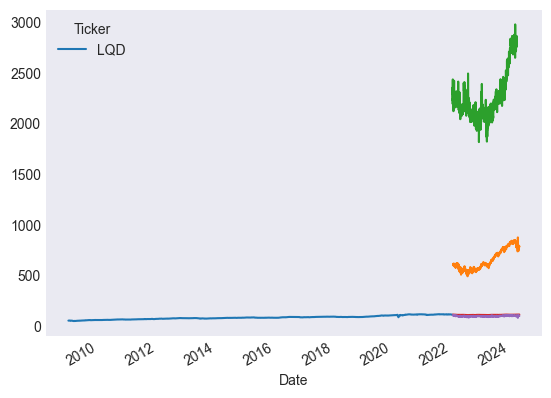

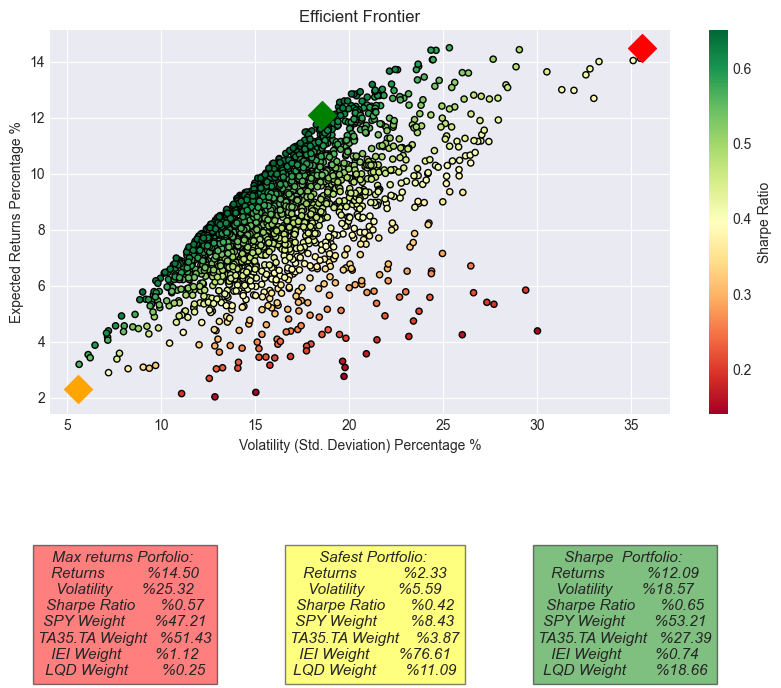

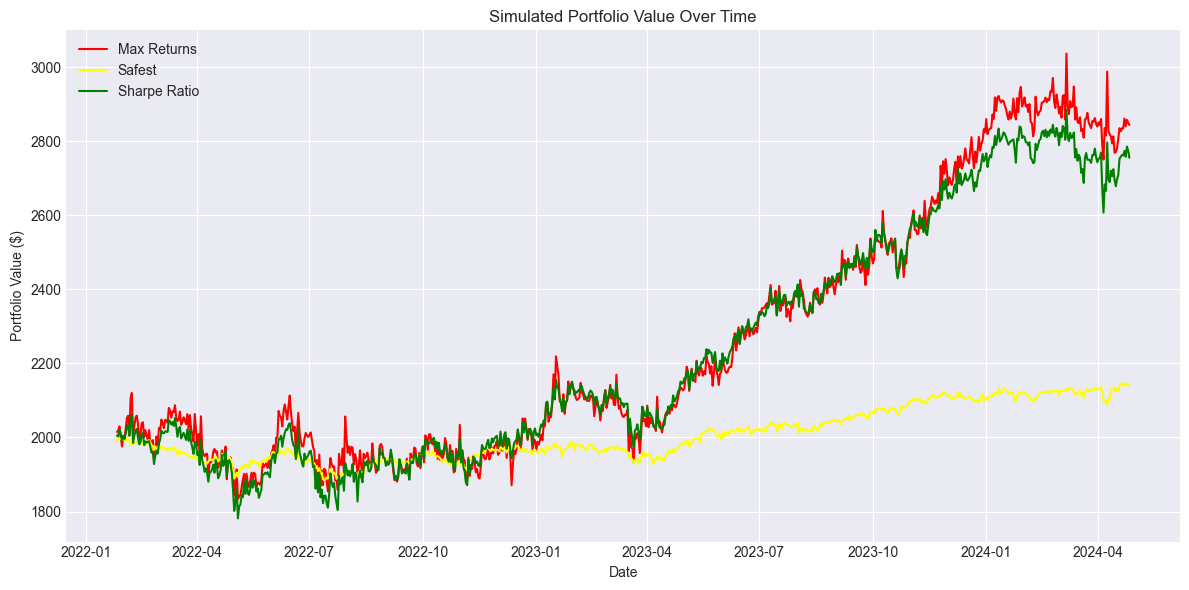

In [30]:
selected = ["SPY", "TA35.TA", "IEI", "LQD"]
record_percentage_to_predict = 0.2
linear_results, linear_metrics = markovich("2009-01-01", "2025-05-07", 2000, selected, record_percentage_to_predict, model_type="linear")

## Run Markovich Model with Random Forest

C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))
d:\studies\s8\algotrade\code\Algotrade\.conda\Lib\site-packages\sklearn\preprocessing\_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Price           Close    HL_PCT PCT_change     Volume       label
Ticker            SPY                             SPY            
Date                                                             
2009-01-02  68.557884  3.995553   2.786374  227566300  107.220833
2009-01-05  68.476753  1.926221   0.237505  240349700  108.088684
2009-01-06  68.934006  1.909794  -0.181544  328260900  109.500969
2009-01-07  66.869019  2.283820  -1.445654  280899200  108.199158
2009-01-08  67.141914  1.583582   0.976040  263834400  108.128166
0.9883990513314005


C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

SPY - R²: 0.9884, RMSE: 13.6375
Price            Close    HL_PCT PCT_change  Volume        label
Ticker         TA35.TA                      TA35.TA             
Date                                                            
2009-01-01  667.390015  2.128178   1.379292       0  1129.430054
2009-01-04  674.239990  1.713038  -0.580967       0  1135.660034
2009-01-05  679.950012  1.438919   0.793068       0  1146.780029
2009-01-06  702.900024  2.960334   2.909095       0  1141.569946
2009-01-07  694.580017  2.172404  -0.465729       0  1144.849976



C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


0.6966185879060343


C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

TA35.TA - R²: 0.6966, RMSE: 155.8770
Price           Close    HL_PCT PCT_change  Volume      label
Ticker            IEI                          IEI           
Date                                                         
2009-01-02  86.699448  1.115960  -0.940388   78500  99.045494
2009-01-05  86.759804  0.435920  -0.225775  487100  98.948090
2009-01-06  86.842941  0.708356   0.410338  363700  98.858765
2009-01-07  86.978760  0.400941   0.243668   67400  99.053642
2009-01-08  87.144867  0.399999   0.130142   34800  99.118515



C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


0.8666395224557683
IEI - R²: 0.8666, RMSE: 2.4258


C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\1360906886.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price           Close    HL_PCT PCT_change   Volume      label
Ticker            LQD                           LQD           
Date                                                          
2009-01-02  54.546375  1.164301  -0.876847  1095800  73.556160
2009-01-05  54.920425  1.638361   1.148279  2938400  73.479782
2009-01-06  55.012585  1.161873   0.217285  2036600  73.511589
2009-01-07  54.551773  1.037407  -0.612401  1675100  73.861809
2009-01-08  54.942139  0.795619   0.735584  1445200  73.861809
0.9263923701606933
LQD - R²: 0.9264, RMSE: 3.3292


C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3285682456.py:27: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(table)
C:\Users\ronsh\AppData\Local\Temp\ipykernel_70444\3285682456.py:30: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = table.pct_change()



--- Max Returns Portfolio ---
Returns           22.412805
Volatility        56.336893
Sharpe Ratio       0.397835
SPY Weight         4.771390
TA35.TA Weight    81.499747
IEI Weight         7.254384
LQD Weight         6.474479
dtype: float64

--- Safest (Min Volatility) Portfolio ---
Returns            3.471007
Volatility        13.637568
Sharpe Ratio       0.254518
SPY Weight        20.106000
TA35.TA Weight     4.972537
IEI Weight        51.556236
LQD Weight        23.365227
dtype: float64

--- Max Sharpe Ratio Portfolio ---
Returns            9.964107
Volatility        23.191647
Sharpe Ratio       0.429642
SPY Weight        19.474781
TA35.TA Weight    30.819921
IEI Weight        27.952301
LQD Weight        21.752998
dtype: float64


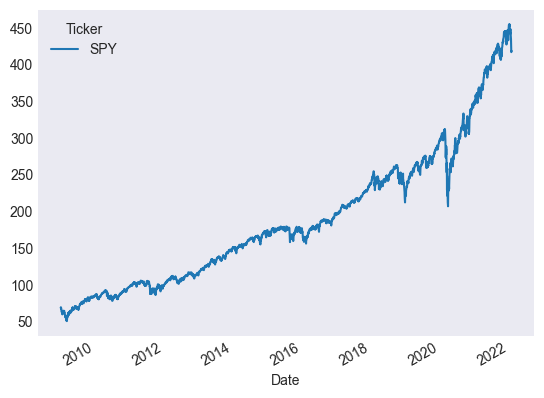

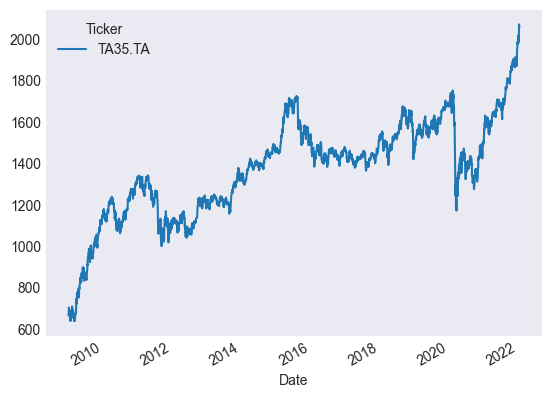

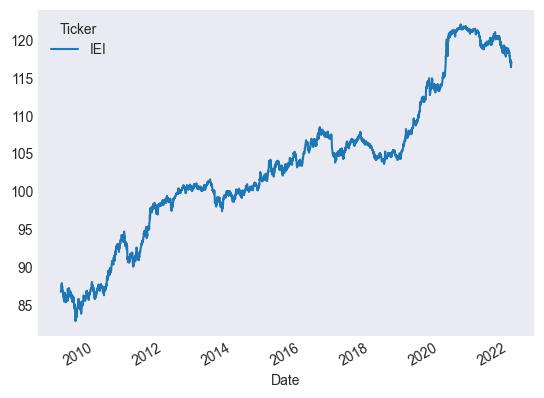

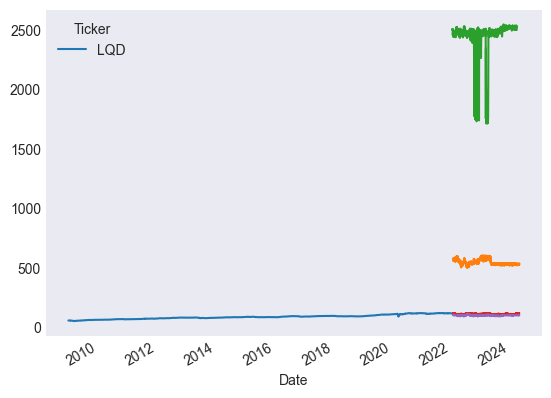

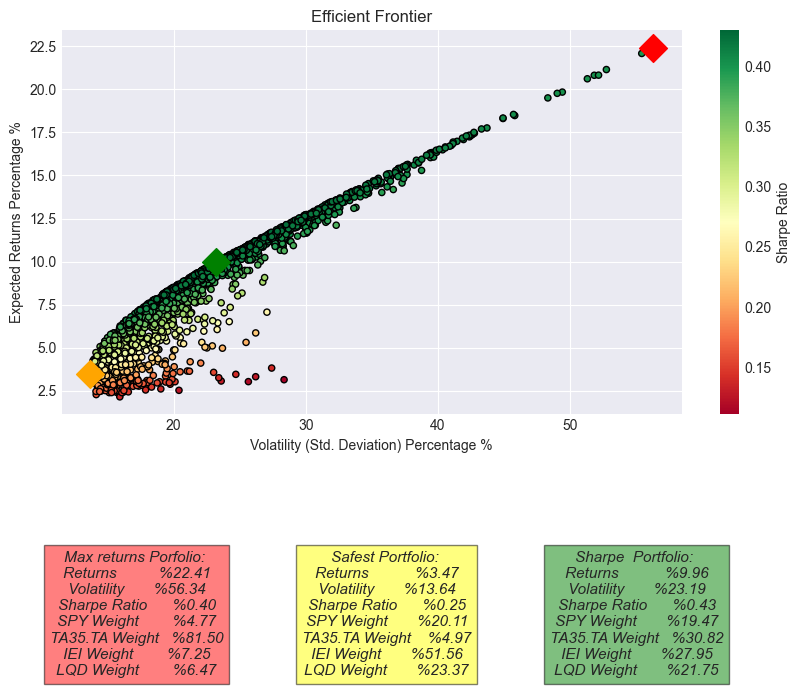

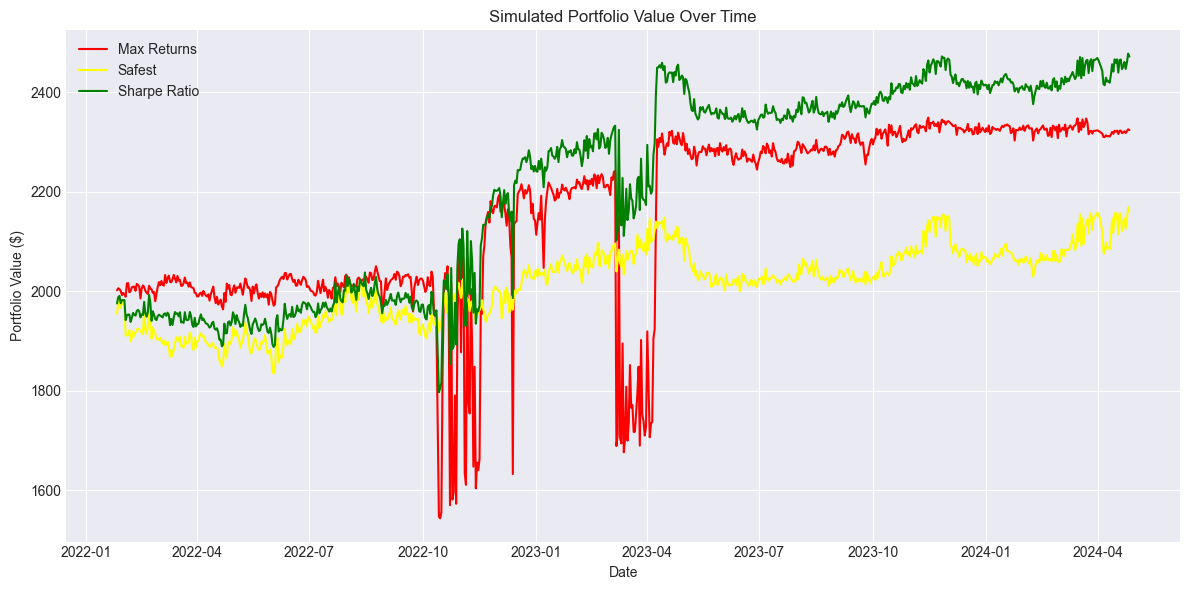

In [8]:
selected = ["SPY", "TA35.TA", "IEI", "LQD"]
record_percentage_to_predict = 0.2
rf_results, rf_metrics = markovich("2009-01-01", "2025-05-07", 2000, selected, record_percentage_to_predict, model_type="rf")

## Models Comparison

,Stock,Model,R2,RMSE
0,SPY,linear,0.961083,26.368589
1,TA35.TA,linear,0.624190,188.341808
2,IEI,linear,0.383620,5.146891
3,LQD,linear,0.564514,7.813999
4,SPY,rf,0.988399,13.637526
5,TA35.TA,rf,0.696619,155.876955
6,IEI,rf,0.866640,2.425822
7,LQD,rf,0.926392,3.329232


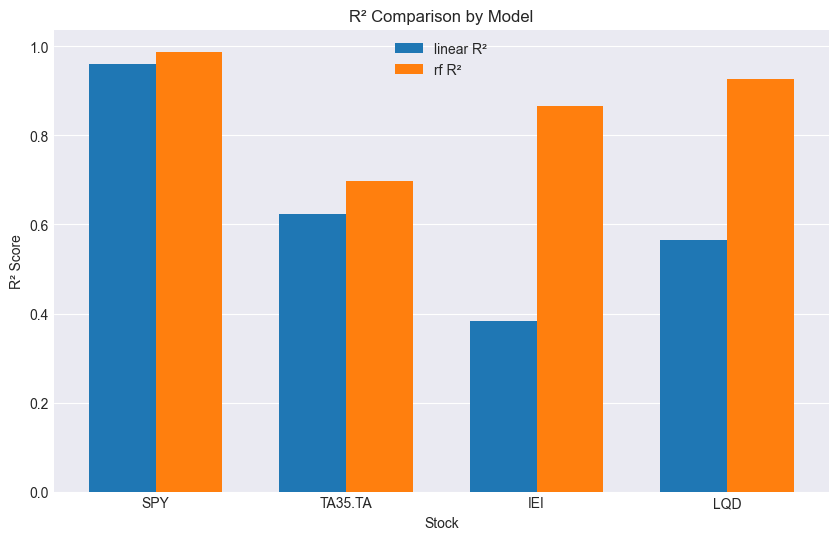

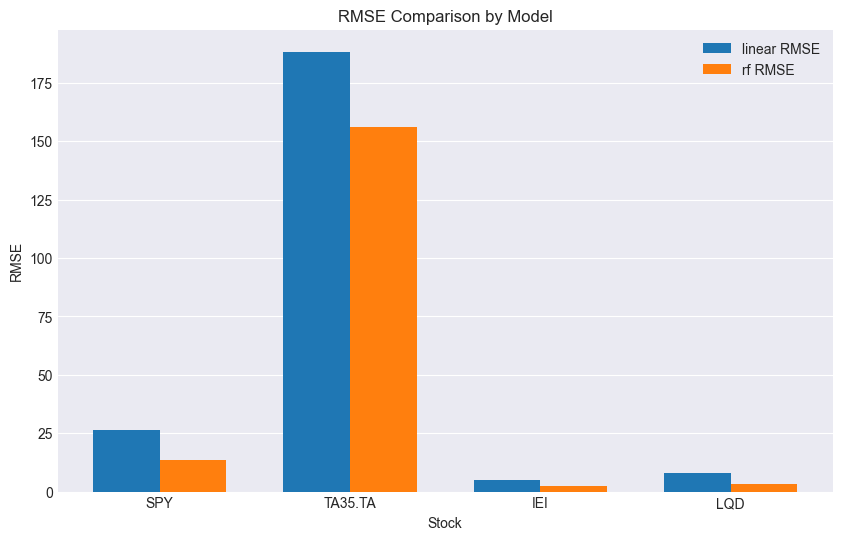

In [31]:
# Combine metrics and create DataFrame
all_metrics = linear_metrics + rf_metrics
metrics_df = pd.DataFrame(all_metrics)
display(metrics_df)

# R² bar chart (side-by-side bars)
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics_df["Stock"].unique()))  # Create x positions for stocks
width = 0.35  # Width of each bar

for i, model_type in enumerate(metrics_df["Model"].unique()):
    subset = metrics_df[metrics_df["Model"] == model_type]
    plt.bar(x + i * width, subset["R2"], width, label=f"{model_type} R²")

plt.xticks(x + width / 2, metrics_df["Stock"].unique())  # Adjust x-axis ticks
plt.title("R² Comparison by Model")
plt.ylabel("R² Score")
plt.xlabel("Stock")
plt.legend()
plt.grid(axis='y')
plt.show()

# RMSE bar chart (side-by-side bars)
plt.figure(figsize=(10, 6))
for i, model_type in enumerate(metrics_df["Model"].unique()):
    subset = metrics_df[metrics_df["Model"] == model_type]
    plt.bar(x + i * width, subset["RMSE"], width, label=f"{model_type} RMSE")

plt.xticks(x + width / 2, metrics_df["Stock"].unique())  # Adjust x-axis ticks
plt.title("RMSE Comparison by Model")
plt.ylabel("RMSE")
plt.xlabel("Stock")
plt.legend()
plt.grid(axis='y')
plt.show()


=== Model Comparison Table ===


,Model,Portfolio,Returns,Volatility,Sharpe Ratio,SPY Weight,TA35.TA Weight,IEI Weight,LQD Weight
0,Linear Regression,Max Sharpe,12.09,18.57,0.65,53.21,27.39,0.74,18.66
1,Linear Regression,Max Returns,14.50,25.32,0.57,47.21,51.43,1.12,0.25
2,Linear Regression,Min Volatility,2.33,5.59,0.42,8.43,3.87,76.61,11.09
3,Random Forest,Max Sharpe,9.96,23.19,0.43,19.47,30.82,27.95,21.75
4,Random Forest,Max Returns,22.41,56.34,0.40,4.77,81.50,7.25,6.47
5,Random Forest,Min Volatility,3.47,13.64,0.25,20.11,4.97,51.56,23.37


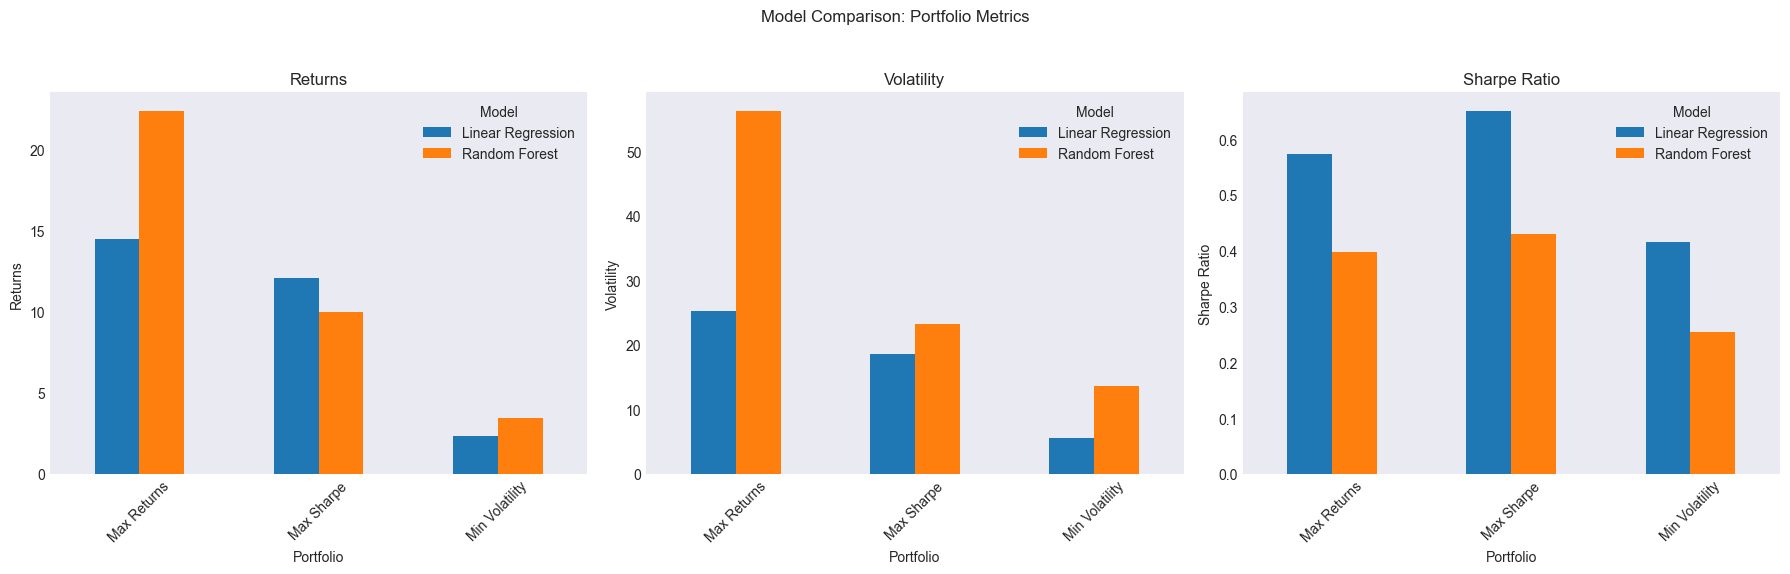


=== Best Model by Metric and Portfolio ===

Best Returns by Portfolio:
  Max Sharpe: Linear Regression (12.09)
  Max Returns: Random Forest (22.41)
  Min Volatility: Random Forest (3.47)

Best Volatility by Portfolio:
  Max Sharpe: Linear Regression (18.57)
  Max Returns: Linear Regression (25.32)
  Min Volatility: Linear Regression (5.59)

Best Sharpe Ratio by Portfolio:
  Max Sharpe: Linear Regression (0.65)
  Max Returns: Linear Regression (0.57)
  Min Volatility: Linear Regression (0.42)

=== Asset Weights by Model and Portfolio ===

Linear Regression - Max Sharpe
  SPY: 53.21%
  TA35.TA: 27.39%
  IEI: 0.74%
  LQD: 18.66%

Linear Regression - Max Returns
  SPY: 47.21%
  TA35.TA: 51.43%
  IEI: 1.12%
  LQD: 0.25%

Linear Regression - Min Volatility
  SPY: 8.43%
  TA35.TA: 3.87%
  IEI: 76.61%
  LQD: 11.09%

Random Forest - Max Sharpe
  SPY: 19.47%
  TA35.TA: 30.82%
  IEI: 27.95%
  LQD: 21.75%

Random Forest - Max Returns
  SPY: 4.77%
  TA35.TA: 81.50%
  IEI: 7.25%
  LQD: 6.47%

Rando

In [32]:
#comparison DataFrame
port_types = ["max_sharpe", "max_returns", "min_volatility"]
model_names = ["Linear Regression", "Random Forest"]
results = []

# Process Linear Regression results
for ptype in port_types:
    d = linear_results[ptype]
    row = {
        "Model": "Linear Regression",
        "Portfolio": ptype.replace("_", " ").title(),
        "Returns": d["Returns"],
        "Volatility": d["Volatility"],
        "Sharpe Ratio": d["Sharpe Ratio"]
    }
    for stock in selected:
        row[f"{stock} Weight"] = d.get(f"{stock} Weight", 0)
    results.append(row)

# Process Random Forest results
for ptype in port_types:
    d = rf_results[ptype]
    row = {
        "Model": "Random Forest",
        "Portfolio": ptype.replace("_", " ").title(),
        "Returns": d["Returns"],
        "Volatility": d["Volatility"],
        "Sharpe Ratio": d["Sharpe Ratio"]
    }
    for stock in selected:
        row[f"{stock} Weight"] = d.get(f"{stock} Weight", 0)
    results.append(row)

comp_df = pd.DataFrame(results)

print("\n=== Model Comparison Table ===")
display(comp_df.round(2))

# grouped bar charts
metrics = ["Returns", "Volatility", "Sharpe Ratio"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    data = comp_df.pivot(index="Portfolio", columns="Model", values=metric)
    data.plot(kind="bar", ax=axes[i], title=metric)
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Model Comparison: Portfolio Metrics")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n=== Best Model by Metric and Portfolio ===")
for metric in metrics:
    print(f"\nBest {metric} by Portfolio:")
    for ptype in comp_df["Portfolio"].unique():
        portfolio_data = comp_df[comp_df["Portfolio"] == ptype]
        if metric == "Volatility":
            best = portfolio_data.loc[portfolio_data[metric].idxmin()]
        else:
            best = portfolio_data.loc[portfolio_data[metric].idxmax()]
        print(f"  {ptype}: {best['Model']} ({best[metric]:.2f})")

print("\n=== Asset Weights by Model and Portfolio ===")
weight_cols = [col for col in comp_df.columns if "Weight" in col]
for idx, row in comp_df.iterrows():
    print(f"\n{row['Model']} - {row['Portfolio']}")
    for col in weight_cols:
        stock = col.replace(" Weight", "")
        print(f"  {stock}: {row[col]:.2f}%")
